<a href="https://colab.research.google.com/github/GabrielaULL/proyecto_ic/blob/main/proyectoIcGabriela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introducción
**Problema seleccionado:**
        
   Se trata de la resolución del Problema del Viajante (TSP: Traveling Salesperson Problem). En este problema se dispone de un conjunto de ciudades y la tarea consiste en determinar la ruta (un ciclo) de menor distancia que permita visitar cada ciudad exactamente una vez y volver al punto de origen.

#2. Descripción de los algoritmos de resolución
* **REPRESENTACIÓN DE UNA SOLUCIÓN AL PROBLEMA**

  La solución se representa mediante una permutación de las ciudades. Cada individuo (solución) es una ruta ciudades y el orden determina la secuencia en la que las visita. Así, una solución ( Ruta ) puede definirse como:

  Ruta = [ciudad_1, ciudad_2, ..., ciudad_n]

  Esta representación garantiza que, si se cuida el operador de cruce y mutación, se respetará la restricción de visitar cada ciudad solo una vez.

  Incialmente se importarán las librerías necesarias, se definirá una instancia de ciudades y sus coordenadas.



In [1487]:
# Importación de las librerías necesarias
import random
import math
import numpy as np
import matplotlib.pyplot as plt
# Definición de ciudades y coordenadas
nombres_ciudades = ["Madrid", "Barcelona", "Valencia", "Zamora"]
coordx = [40.4168, 41.3851, 39.4699, 41.5033]
coordy = [-3.7038, 2.1734, -0.3763, -5.7470]

A continuación se encuentran las Funciones para:
* calcular la distancia euclidiana entre dos ciudades ciudades
* obtener la matriz distancias simétricas entre las ciudades.
* Función de distancia total de una ruta (con recorrido del ciclo cerrado)

In [1488]:
def distancia(coordx1, coordy1, coordx2,coordy2):
    distancia = math.sqrt((coordx1 - coordx2)**2 + (coordy1 - coordy2)**2)
    return distancia
def calcular_matriz_distancias(nombres_ciudades):
    matriz = [[0 for _ in range(n)] for _ in range(n)] #Creando una matriz de dimensiones nxn y llenándola con 0s, donde n es el num_ciudades
    for i in range(n):
        for j in range(n):
            matriz[i][j] = distancia(coordx[i], coordy[i], coordx[j],coordy[j]) #Llenando la matriz con las distancias entre ciudades, considerando que las filas corresponden a las n ciudades y las columnas también corresponden a las n ciudades, para establecer todas las parejas
    return matriz
def calcular_distancias_utiles(matriz, nombres_ciudades): #Esta función no es útil en el código, pero permite ver las distancias útiles para comprobar la eficiencia del algoritmo
    distancias_utiles = []
    for i in range(len(nombres_ciudades)):
        for j in range(i + 1, len(nombres_ciudades)):  #Comenzamos desde i+1 para evitar duplicados
            distancia = matriz[i][j]
            distancias_utiles.append((nombres_ciudades[i], nombres_ciudades[j], distancia))
    return distancias_utiles
def distancia_ruta(ruta, coordx, coordy, nombres_ciudades):
    total = 0
    n = len(nombres_ciudades)
    for i in range(n):
        ciudad1_index = nombres_ciudades.index(ruta[i])  # Obteniendo índice de la ciudad en la lista de nombres
        ciudad2_index = nombres_ciudades.index(ruta[(i+1) % n])  # Obteniendo índice de la siguiente ciudad, [(i+1) % n] puede dar como resultado 3 casos: si (i+1)<n el resultado es (i+1), si (i+1)=n el resultado es 0, si (i+1)>n el resultado es la parte entera, pero que en este caso no aplicaría
        # Extrayendo coordenadas usando índices
        x1, y1 = coordx[ciudad1_index], coordy[ciudad1_index]
        x2, y2 = coordx[ciudad2_index], coordy[ciudad2_index]
        total += distancia(x1, y1, x2, y2)  # Calcula la distancia entre ambas ciudades
    return total

* **Definición de la función de fitness**

    La función de fitness nos ayudará a evaluar la calidad de una solución. En el contexto del TSP, dado que el objetivo es minimizar la distancia, se suele definir el fitness como el inverso de la distancia total, de forma que soluciones con menor recorrido tengan un valor de fitness mayor.


In [1489]:
def fitness(ruta, coordx, coordy, nombres_ciudades):
    dist = distancia_ruta(ruta, coordx, coordy, nombres_ciudades)
    fitness_solucion = 1.0 / dist if dist > 0 else float('inf')
    return fitness_solucion

* **Función de Inicialización**

    Se crea una población compuesta por rutas aleatorias.

In [1490]:
def crear_poblacion_inicial(tam_poblacion, nombres_ciudades):
    poblacion = [random.sample(nombres_ciudades, len(nombres_ciudades)) for _ in range(tam_poblacion)]
    return poblacion


---


* **IMPLEMENTACIÓN DE LA BÚSQUEDA ALEATORIA**

    Se genera una población inicial de rutas aleatorias y se evalúa sus distancias. Luego, se busca la mejor solución seleccionando la ruta con el menor valor de distancia, utilizando la función de fitness. Finalmente, se imprime la mejor ruta encontrada y su distancia total.

In [1491]:
def algoritmo_por_busqueda_aleatoria(nombres_ciudades, coordx, coordy, tam_poblacion):
    poblacion = crear_poblacion_inicial(tam_poblacion, nombres_ciudades)
    #Imprimiendo Las Rutas la las distancias generadas con la función encargadad de crear la población inicial
    #print("\nPOBLACIÓN INICIAL Y DISTANCIAS DE RUTAS:\n") #Lo comenté para los experimentos
    for i, ruta in enumerate(poblacion):
        total = distancia_ruta(ruta, coordx, coordy, nombres_ciudades)
        #print(f"Ruta {i+1}: {ruta}, Distancia: {total}") #Imprimiendo la distancia de cada ruta generada (Lo comenté para los experimentos)
    #Determinando la mejor ruta encontrada
    mejor_solucion = None
    mejor_fitness = float('-inf')  #Inicializa con el peor fitness posible
    for solucion in poblacion:
        fitness_solucion = fitness(solucion, coordx, coordy, nombres_ciudades)  ##Llama a la función fitness enviando como parámetro una solución (correspondiente a cada uno de los elementos de la población generada)
        if fitness_solucion > mejor_fitness:
            mejor_fitness = fitness_solucion
            mejor_distancia = 1.0 / mejor_fitness
            mejor_solucion = solucion
    return mejor_solucion, mejor_distancia



---



* **IMPLEMENTACIÓN DEL ALGORITMO EVOLUTIVO**

  * **Selección de padres mediante torneo**

In [1492]:
def select_parents_torneo(poblacion, fitnesses, tam_poblacion):
    parents = []
    for _ in range(2):
        padre1_index = random.randint(0, tam_poblacion - 1)
        padre2_index = random.randint(0, tam_poblacion - 1)

        if fitnesses[padre1_index] > fitnesses[padre2_index]:
            parents.append(poblacion[padre1_index])
        else:
            parents.append(poblacion[padre2_index])
    return parents

*  
  * **Mutación**

    Aplica mutación al individuo intercambiando aleatoriamente dos ciudades.

In [1493]:
def mutacion(individuo, tasa_mutacion):
    tam = len(individuo)
    for i in range(tam):
        if random.random() < tasa_mutacion:
            j = random.randrange(tam)
            individuo[i], individuo[j] = individuo[j], individuo[i]
    return individuo

  *

    * **Cruce PMX (Partially Mapped Crossover)**

      Se selecciona un segmento aleatorio de padre1 y se establece un mapeo para mantener la validez de la permutación.

In [1494]:
def pmx_crossover(padre1, padre2):
    tam = len(padre1)
    hijo = [None] * tam #Se inicializa la lista con un tamaño establecido con None en todas sus posiciones
    inicio, fin = sorted([random.randint(0, tam - 1) for _ in range(2)]) #Se selecciona dos puntos de cruce aleatorios
    hijo[inicio:fin+1] = padre1[inicio:fin+1] #Se copia el segmento de padre1 en el hijo
    mapeo = {padre1[i]: padre2[i] for i in range(inicio, fin+1)}  #Se mapea, es decir que se arman correspondencias entre padre1 y padre2 en cada una de las posiciones desde el inicio hasta el fin
    for i in range(tam): #Completar el hijo con valores de padre2, evitando repeticiones
        if hijo[i] is None: #El código ejecuta el siguiente bloque si la posición i del hijo está vacía
            valor = padre2[i] #Se copia la posición i del padre2 en la variable valor
            while valor in hijo: #Se entra en el siguiente bucle cuando el contenido de la variable valor ya está en el hijo, es decir cuando la ciudad ya forma parte de la nueva ruta que constituye el hijo
                valor = mapeo.get(valor, valor) #Se obtiene del mapeo previo, la correspondencia y se copia ese valor en la variable valor
            hijo[i] = valor #Se copia el contenido de la variable valor en la posición i del hijo
    return hijo

  *

    * **Algoritmo Evolutivo**

        Se inicia con una población de rutas aleatorias, se evalúa su calidad en función de la distancia total y se seleccionan los mejores individuos para generar nuevas soluciones. A través del cruce PMX y la mutación aleatoria, se introducen variaciones que permiten mejorar progresivamente la ruta óptima en cada generación. Finalmente, el algoritmo encuentra la mejor ruta minimizando la distancia del recorrido.

In [1495]:
def algoritmo_evolutivo(nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion):
    poblacion = crear_poblacion_inicial(tam_poblacion, nombres_ciudades) #Se llama a la población inicial
    fitnesses = [fitness(individuo, coordx, coordy, nombres_ciudades) for individuo in poblacion] #Se calcula fitness de cada individuo de la solución
    mejor_ruta = min(poblacion, key=lambda ruta: distancia_ruta(ruta, coordx, coordy, nombres_ciudades)) #Se encuentra la ruta con la menor distancia usando 'min' y una función lambda que aplica 'distancia_ruta'
    mejor_distancia = distancia_ruta(mejor_ruta, coordx, coordy, nombres_ciudades) #Se encuentra la mejor distancia en base a la mejor ruta
    for gen in range(generaciones):
        nueva_poblacion = [] #Se define una nueva lista de población
        for _ in range(tam_poblacion):
            padre1, padre2 = select_parents_torneo(poblacion, fitnesses, tam_poblacion) #Se crean dos padres con torneo binari
            hijo = pmx_crossover(padre1, padre2) #Se crea el hijo a través de la función cruce
            hijo = mutacion(hijo, tasa_mutacion) #Se muta al hijo
            nueva_poblacion.append(hijo) #Se añade el hijo creado y mutado a la nueva lista de población
        poblacion = nueva_poblacion #Esa nueva lista de población se copia en la lista población
        fitnesses = [fitness(individuo, coordx, coordy, nombres_ciudades) for individuo in poblacion] #Se vuelve a calcular el fitness de la población
        candidato = min(poblacion, key=lambda ruta: distancia_ruta(ruta, coordx, coordy, nombres_ciudades)) #Se evalúa la mejor solución de la nueva generación (candidato)
        dist_candidato = distancia_ruta(candidato, coordx, coordy, nombres_ciudades) #Se encuentra la distancia de recorrido del candidato
        if dist_candidato < mejor_distancia: #Si la distancia de recorrido del candidato es menor a la mejor distancia previa se establece que la mejor ruta es la del candidato de la nueva generación
            mejor_ruta = candidato
            mejor_distancia = dist_candidato
        #print(f"Generación {gen+1}: Mejor distancia = {mejor_distancia:.4f}")
    return mejor_ruta, mejor_distancia

#3. Experimentación

A continuación se imprimen:

*   La listas de ciudades
*   Las coordenadas de cada ciudad
*   La matriz de distancia entre ciudades
*   Distancias entre ciudades

*   Distancias útiles entre ciudades



In [1496]:
# Probando el código
n=len(nombres_ciudades)
# Imprimiendo la lista de ciudades
print("\nLISTA DE CIUDADES: \n")
for i in range(len(nombres_ciudades)):
    print(nombres_ciudades[i])
print("\n")
# Imprimiendo las coordenadas de las ciudades
print("\nCOORDENADAS DE LAS CIUDADES: \n")
for i in range(len(nombres_ciudades)):
  print("Coordenadas de ", nombres_ciudades[i], ": (", coordx[i], ", ",coordy[i], ")")
print("\n")
#Imprimiendo la matriz de distancias entre ciudades
matriz = calcular_matriz_distancias(nombres_ciudades)
print("\nMATRIZ DE DISTANCIAS ENTRE CIUDADES DE ", n, " FILAS x ", n, " COMLUMNAS:\n" )
for fila in matriz:
    print(fila)
print("\n")
# Imprimiendo la matriz de distancias, enumerando cada una de las distancias (que serían en total nxn)
print("\nDISTANCIAS ENTRE CIUDADES:\n")
for i in range(len(nombres_ciudades)):
    for j in range(len(nombres_ciudades)):
        #print(f"Distancia entre ciudad {i+1} y ciudad {j+1}: {matriz[i][j]:.2f}")
        print(f"Distancia entre ciudad {i+1} y ciudad {j+1}: {matriz[i][j]:.2f} ({nombres_ciudades[i]} y {nombres_ciudades[j]}) ")
print("\n")
#Llamando a la funcion calcular_distancias_utiles, pero dejar si es necesario sino eliminarla y descomentar las líneas previas que hacen la impresión sin llamar a una función.
distancias_utiles = calcular_distancias_utiles(matriz, nombres_ciudades)
num_distancias_utiles = int(((n*n)-n)/2)
print("\nDISTANCIAS ÚTILES ENTRE CIUDADES (sin considerar las distancias repetidas ni las distancias entre una ciudad y sí misma)\n")
for i in range(num_distancias_utiles):
  print(distancias_utiles[i])
print("\n")


LISTA DE CIUDADES: 

Madrid
Barcelona
Valencia
Zamora



COORDENADAS DE LAS CIUDADES: 

Coordenadas de  Madrid : ( 40.4168 ,  -3.7038 )
Coordenadas de  Barcelona : ( 41.3851 ,  2.1734 )
Coordenadas de  Valencia : ( 39.4699 ,  -0.3763 )
Coordenadas de  Zamora : ( 41.5033 ,  -5.747 )



MATRIZ DE DISTANCIAS ENTRE CIUDADES DE  4  FILAS x  4  COMLUMNAS:

[0.0, 5.956432214841364, 3.459606315753282, 2.3141193767824513]
[5.956432214841364, 0.0, 3.188880858545831, 7.921281929081934]
[3.459606315753282, 3.188880858545831, 0.0, 5.742746211526329]
[2.3141193767824513, 7.921281929081934, 5.742746211526329, 0.0]



DISTANCIAS ENTRE CIUDADES:

Distancia entre ciudad 1 y ciudad 1: 0.00 (Madrid y Madrid) 
Distancia entre ciudad 1 y ciudad 2: 5.96 (Madrid y Barcelona) 
Distancia entre ciudad 1 y ciudad 3: 3.46 (Madrid y Valencia) 
Distancia entre ciudad 1 y ciudad 4: 2.31 (Madrid y Zamora) 
Distancia entre ciudad 2 y ciudad 1: 5.96 (Barcelona y Madrid) 
Distancia entre ciudad 2 y ciudad 2: 0.00 (Barce

---

**EJECUCIÓN DE LOS ALGORITMOS:**

*   POR BÚSQUEDA ALEATORIA
*   GENERATIVO



In [1497]:
def ejecucion(tam_poblacion, generaciones, tasa_mutacion):
    # Mostrando la mejor solución encontrada con el algoritmo por búsqueda aleatoria
    mejor_ruta, mejor_distancia = algoritmo_por_busqueda_aleatoria(nombres_ciudades, coordx, coordy, tam_poblacion)
    print("\n\nRESULTADOS:")
    print("\n* RESULTADOS DE ALGORITMO POR BÚSQUEDA ALEATORIA")
    print("   Mejor ruta encontrada:", mejor_ruta)
    print("   Distancia total del ciclo:", mejor_distancia)
    # Mostrando la mejor solución encontrada con el algoritmo evolutivo
    print("\n* RESULTADOS DE ALGORITMO EVOLUTIVO")
    mejor_ruta, mejor_distancia = algoritmo_evolutivo(nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)
    print("   Mejor ruta encontrada:", mejor_ruta)
    print("   Distancia total del ciclo:", mejor_distancia)

---
* **Descripción de los experimentos**

  * Algoritmos involucrados
    * Búsqueda aleatoria: Se generan múltiples soluciones al azar, evaluando su calidad para identificar la mejor ruta.
    * Algoritmo evolutivo: Se aplica selección, cruce y mutación sobre una población inicial de rutas para mejorar progresivamente la solución.
  * Parámetros utilizados
    * Tamaño de población
    * Número de generaciones en evolución
    * Tasa de mutación
  * Procedimiento estadístico: Histograma de frecuencias
  

In [1498]:
def analizar_experimentos(num_experimentos, nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion):
    # Listas para almacenar las distancias obtenidas
    distancias_aleatorias = []
    distancias_evolutivas = []
    for _ in range(num_experimentos): #Ejecutando cada algoritmo varias veces y guardar resultados
        mejor_ruta_aleatoria, mejor_distancia_aleatoria = algoritmo_por_busqueda_aleatoria(nombres_ciudades, coordx, coordy, tam_poblacion)
        mejor_ruta_evolutiva, mejor_distancia_evolutiva = algoritmo_evolutivo(nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)
        distancias_aleatorias.append(mejor_distancia_aleatoria)
        distancias_evolutivas.append(mejor_distancia_evolutiva)
    plt.figure(figsize=(8, 6)) #Configura el tamaño de la figura
    plt.hist(distancias_aleatorias, bins=10, alpha=0.6, color='red', label='Búsqueda Aleatoria') #Histograma de búsqueda aleatoria
    plt.hist(distancias_evolutivas, bins=10, alpha=0.6, color='blue', label='Algoritmo Evolutivo') # Histograma de algoritmo evolutivo
    plt.title("Distribución de distancias obtenidas por cada algoritmo")
    plt.xlabel("Distancia total de la ruta")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(True)
    plt.show() #Mostrando el gráfico

---
# 4. Resultados y Discusión
   A continuación se visualizan y se discuten los resultados en dos etapas, cambiando el tamaño de la población y dentro de cada etapa habrán dos gráficos para los cuale se usa diferentes número de experimentos.



RESULTADOS:

* RESULTADOS DE ALGORITMO POR BÚSQUEDA ALEATORIA
   Mejor ruta encontrada: ['Madrid', 'Zamora', 'Valencia', 'Barcelona']
   Distancia total del ciclo: 17.202178661695974

* RESULTADOS DE ALGORITMO EVOLUTIVO
   Mejor ruta encontrada: ['Zamora', 'Madrid', 'Valencia', 'Barcelona']
   Distancia total del ciclo: 16.8838884801635


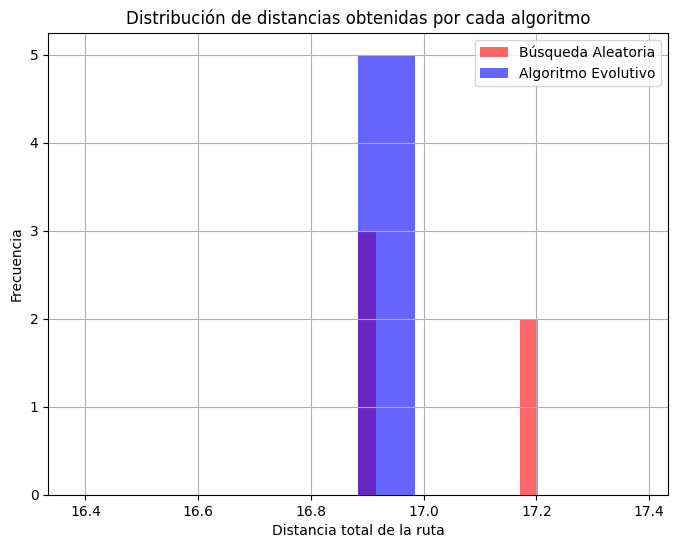

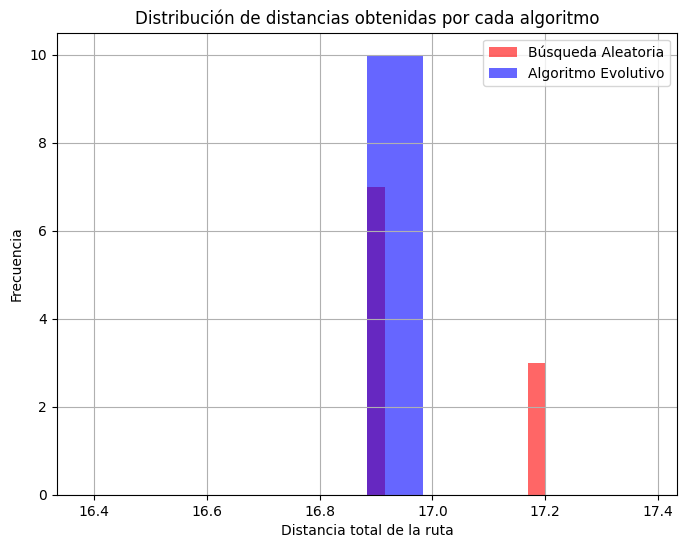

In [1499]:
# Parámetros del algoritmo evolutivo para el primer análisis
tam_poblacion = 4
generaciones = 10
tasa_mutacion = 0.1
ejecucion(tam_poblacion, generaciones, tasa_mutacion)
num_experimentos = 5
analizar_experimentos(num_experimentos, nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)
num_experimentos = 10
analizar_experimentos(num_experimentos, nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)

* DISCUSIÓN:
  - En el primer gráfico (5 experimentos) se observa una distribución más limitada, ya que el número de pruebas es reducido y la variabilidad es más alta, dado que hay menos datos para establecer un patrón de comportamiento claro.
  - En el segundo gráfico (10 experimentos) la distribución de los resultados comienza a estabilizarse, mostrando patrones más claros y la variabilidad en la distancia obtenida es menor, indicando mayor confiabilidad del modelo.
  - Al aumentar el número de experimentos, se reduce el efecto de valores atípicos que pueden afectar la interpretación de los datos en pruebas limitadas y se obtiene una mejor visión sobre qué algoritmo ofrece una optimización más estable.





RESULTADOS:

* RESULTADOS DE ALGORITMO POR BÚSQUEDA ALEATORIA
   Mejor ruta encontrada: ['Zamora', 'Barcelona', 'Valencia', 'Madrid']
   Distancia total del ciclo: 16.8838884801635

* RESULTADOS DE ALGORITMO EVOLUTIVO
   Mejor ruta encontrada: ['Valencia', 'Madrid', 'Zamora', 'Barcelona']
   Distancia total del ciclo: 16.8838884801635


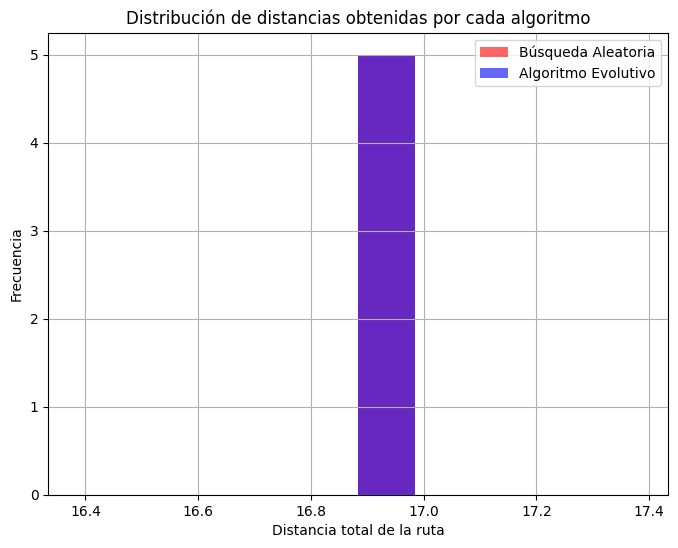

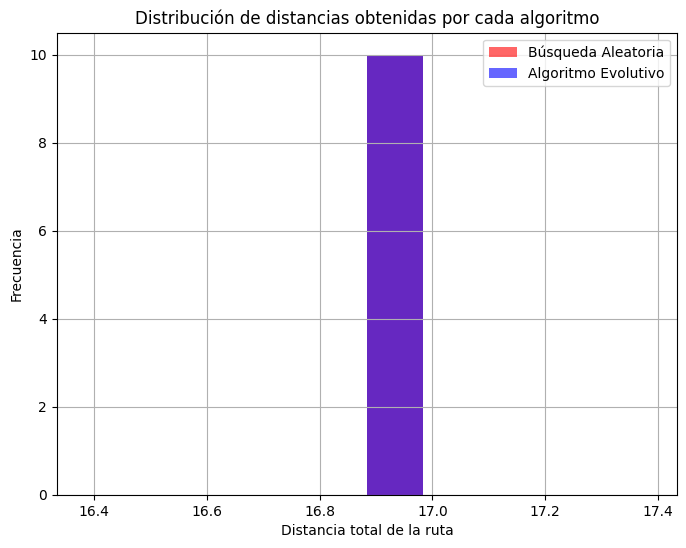

In [1500]:
# Parámetros del algoritmo evolutivo para el segundo análisis
tam_poblacion = 8
generaciones = 10
tasa_mutacion = 0.1
ejecucion(tam_poblacion, generaciones, tasa_mutacion)
num_experimentos = 5
analizar_experimentos(num_experimentos, nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)
num_experimentos = 10
analizar_experimentos(num_experimentos, nombres_ciudades, coordx, coordy, tam_poblacion, generaciones, tasa_mutacion)

**DISCUSIÓN**
- En el primer gráfico (5 experimentos) la distribución de las distancias se presenta más variada en comparación con el caso de 4 rutas, lo que sugiere que el modelo aún está explorando una mayor cantidad de combinaciones posibles. También se observa una mejora en la estabilidad de los resultados, pero con cierta variabilidad en las rutas óptimas obtenidas.
- En el segundo gráfico (10 experimentos) la tendencia comienza a consolidarse, mostrando una mayor uniformidad en los valores de distancia óptima, la variabilidad de las soluciones se reduce, lo que indica que la evolución del modelo permite mejorar la confiabilidad de las rutas obtenidas.
- Al aumentar el númerod de experimentos hay una mayor diversidad en las soluciones generadas, permitiendo explorar un espacio de búsqueda más amplio, también se observa menos variabilidad en la distancia final, lo que indica que el aumento en el tamaño de la población ha favorecido la estabilidad del algoritmo, y los gráficos muestran una mayor capacidad de convergencia.


---
# 5. Conclusiones

- El algoritmo evolutivo es más estable
  - A medida que se aumenta el número de rutas en la población, el algoritmo encuentra soluciones más confiables.
  - Las mejores rutas se repiten más, lo que significa que el algoritmo mejora su eficiencia con más intentos.
- La búsqueda aleatoria es menos efectiva
  - Cuando las rutas se crean de manera aleatoria, algunas pueden ser buenas, pero muchas son poco eficientes.
  - El algoritmo evolutivo aprende y mejora las rutas con cada paso, mientras que la búsqueda aleatoria no tiene forma de mejorar por sí sola.
-  Más experimentos ayudan a obtener mejores resultados
  - Al realizar más pruebas, se obtiene una mejor idea de qué algoritmo funciona mejor.
  - Si se ejecutan pocos experimentos, los resultados pueden ser poco confiables, pero con más pruebas se puede ver si el algoritmo realmente optimiza las rutas.


---
#6. Bibliografía

- Eiben, A. E., & Smith, J. E. (2015). Introduction to Evolutionary Computing (2ª ed.). Springer. https://doi.org/10.1007/978-3-662-44874-8
- Wikipedia. Algoritmo evolutivo. Wikipedia, la enciclopedia libre. https://es.wikipedia.org/wiki/Algoritmo_evolutivo